In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

import plotly.graph_objs as go
import plotly
plotly.__version__

'4.5.0'

In [325]:
sns.set(style='darkgrid')
mpl.rcParams['figure.figsize'] = (12,15)

In [326]:
dataPath_Raw = ("data/COVID_Flat_Table_Complete.csv")
#dataPath_Processed = ("../data/processed/")

pd.set_option("display.max_rows", 500)

In [327]:
df_analyse = pd.read_csv(dataPath_Raw, sep=",")
df_analyse.sort_values('date', ascending = True).tail()

,date,Italy,US,Spain,Germany,India,"Korea, South",China,Brazil,Afghanistan,...,Burundi,Sierra Leone,Malawi,South Sudan,Western Sahara,Sao Tome and Principe,Yemen,Comoros,Tajikistan,Lesotho
145,2020-06-15,237290,2114026,244109,187682,343091,12155,84378,888271,25527,...,85,1176,555,1693,9,662,844,176,5097,4
146,2020-06-16,237500,2137731,244328,188252,354065,12198,84422,923189,26310,...,104,1225,564,1776,9,671,885,197,5160,4
147,2020-06-17,237828,2163290,244683,188604,366946,12257,84458,955377,26874,...,104,1249,572,1813,9,683,902,197,5221,4
148,2020-06-18,238159,2191052,245268,189817,380532,12306,84494,978142,27532,...,104,1272,592,1830,9,688,909,210,5279,4
149,2020-06-19,238011,2220961,245575,190299,395048,12373,84494,1032913,27878,...,104,1298,620,1864,9,693,919,210,5338,4


In [328]:
df_analyse.Germany;
a = len(df_analyse.Germany)
print(a)

150


In [329]:
N0 = 83000000
beta = 0.4
gamma = 0.1

# Reproduction number beta/gamma

# S + I + R = N

I0 = a
S0 = N0 - I0
R0 = 0

print(S0)

82999850


In [330]:
def SIR_model(SIR, beta, gamma):
    
    S,I,R = SIR
    dS = -beta * S * I/N0
    dI = beta * S * I/N0 - gamma * I
    dR = gamma * I
    
    return([dS, dI, dR])
    

In [331]:
SIR = np.array([S0,I0,R0])

propagation_rates = pd.DataFrame(columns={'Susceptible':S0,
                                          'Infected':I0,
                                          'Recovered':R0                                                  
                                         })
                                 
for each in np.arange(100):
    new_delta_vector = SIR_model(SIR, beta, gamma)
    SIR = SIR + new_delta_vector
    
    propagation_rates = propagation_rates.append({'Susceptible':SIR[0],
                                                  'Infected':SIR[1],
                                                  'Recovered':SIR[2],                         
                                                },ignore_index=True
                                                )
                                 



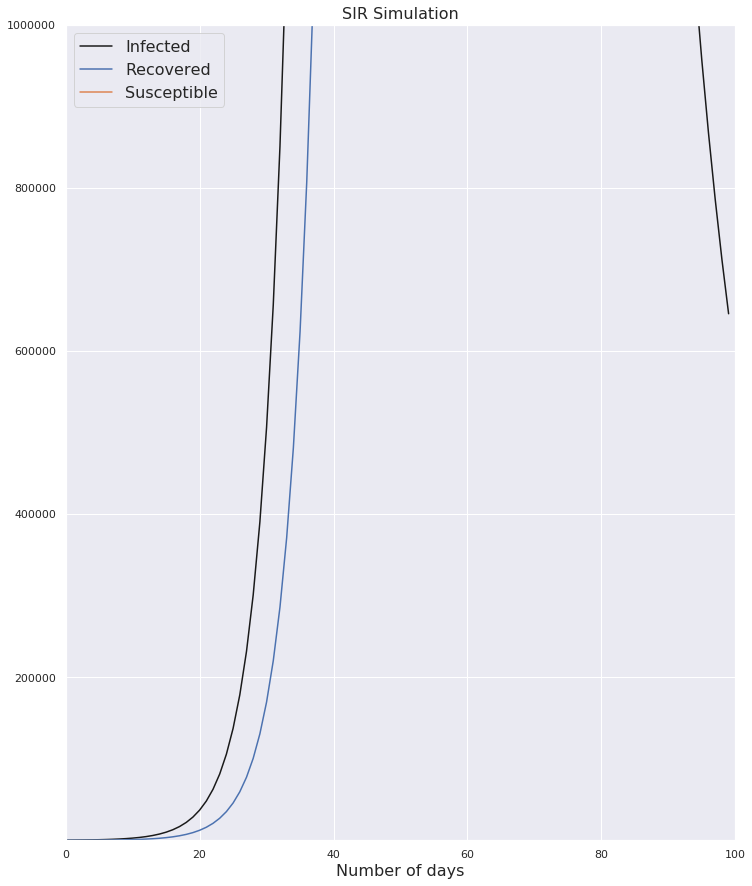

In [332]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(propagation_rates.index, propagation_rates.Infected, label = 'Infected', color= 'k')
ax1.plot(propagation_rates.index, propagation_rates.Recovered, label = 'Recovered')
ax1.plot(propagation_rates.index, propagation_rates.Susceptible, label = 'Susceptible')

ax1.set_ylim(10,1000000)
ax1.set_xlim(0,100)
ax1.set_yscale('linear')
ax1.set_title('SIR Simulation', size= 16)
ax1.set_xlabel('Number of days', size=16)
ax1.legend(loc='best',
          prop={'size':16})

## Fitting the parameters

In [333]:
from scipy import optimize
from scipy import integrate

In [334]:
ydata = np.array(df_analyse.US[90:])   #90
time = np.arange(len(ydata))

In [335]:
I0 = ydata[0]
S0 = 328000000
R0 = 0
beta

0.4

In [336]:
print(I0)

809213


In [337]:
def SIR_model_fit(SIR, time, beta, gamma):
    
    S,I,R = SIR
    dS = -beta * S * I/N0
    dI = beta * S * I/N0 - gamma * I
    dR = gamma * I
    
    return([dS, dI, dR])
    

In [338]:
def fit_odeint(x,beta,gamma):
    return integrate.odeint(SIR_model_fit, (S0,I0,R0), time, args=(beta, gamma))[:,1]

# [,:1] infected rate

In [339]:
# Integrate

popt = [0.4, 0.1]  #beta, gamma

fit_odeint(time, *popt)

array([8.09213000e+05, 3.53836367e+06, 1.49918676e+07, 5.61753288e+07,
       1.47975985e+08, 2.29821243e+08, 2.50771762e+08, 2.40136372e+08,
       2.21172755e+08, 2.01341828e+08, 1.82597170e+08, 1.65375886e+08,
       1.49701226e+08, 1.35482823e+08, 1.22602853e+08, 1.10942106e+08,
       1.00387982e+08, 9.08367013e+07, 8.21935534e+07, 7.43724757e+07,
       6.72954238e+07, 6.08916953e+07, 5.50972715e+07, 4.98542027e+07,
       4.51100403e+07, 4.08173195e+07, 3.69330879e+07, 3.34184777e+07,
       3.02383181e+07, 2.73607844e+07, 2.47570796e+07, 2.24011464e+07,
       2.02694072e+07, 1.83405278e+07, 1.65952038e+07, 1.50159680e+07,
       1.35870153e+07, 1.22940446e+07, 1.11241156e+07, 1.00655196e+07,
       9.10766173e+06, 8.24095572e+06, 7.45672735e+06, 6.74712790e+06,
       6.10505551e+06, 5.52408418e+06, 4.99839940e+06, 4.52273999e+06,
       4.09234542e+06, 3.70290819e+06, 3.35053071e+06, 3.03168629e+06,
       2.74318385e+06, 2.48213597e+06, 2.24593003e+06, 2.03220200e+06,
      

In [340]:
popt, pcov = optimize.curve_fit(fit_odeint, time, ydata)
perr = np.sqrt(np.diag(pcov))


In [341]:
print('Standard deviation errors : ', str(perr), 'Infection Start : ', ydata[0])


Standard deviation errors :  [0.00146802 0.00548592] Infection Start :  809213


In [342]:
fitted = fit_odeint(time, *popt)

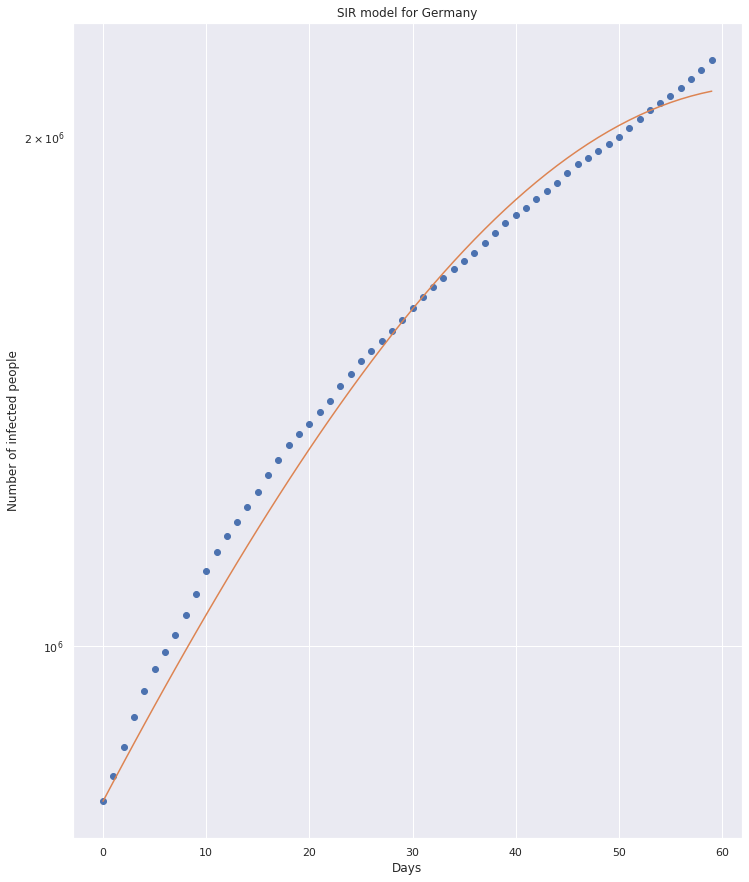

Optimal Parameters : beta =  0.07578264602066746 gamma =  0.27286813452937564
Reproduction number, R0 :  0.27772625833123465


In [343]:
plt.semilogy(time, ydata, 'o')
plt.semilogy(time, fitted)
plt.title('SIR model for Germany')
plt.ylabel('Number of infected people')
plt.xlabel('Days')
plt.show()

beta_fit = popt[0]
gamma_fit = popt[1]

print('Optimal Parameters : beta = ', popt[0], 'gamma = ', popt[1])
print('Reproduction number, R0 : ', popt[0]/popt[1])

In [348]:
# %load ../src/visualization/visualize.py
import pandas as pd
import numpy as np

import dash
dash.__version__
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output,State

import plotly.graph_objects as go

import os
print(os.getcwd())

# COVID_final_set_TEST - Doubling rate modified for preventing breaks in the graph

df_input_large=pd.read_csv('/home/ubuntu/Desktop/DataScience/ads_covid-19/data/processed/COVID_final_set.csv',sep=',', error_bad_lines=False)


fig = go.Figure()

app = dash.Dash()
app.layout = html.Div([

    dcc.Markdown('''
    #  Applied Data Science on COVID-19 data

    Goal of the project is to teach data science by applying a cross industry standard process,
    it covers the full walkthrough of: automated data gathering, data transformations,
    filtering and machine learning to approximating the doubling time, and
    (static) deployment of responsive dashboard.

    '''),

    dcc.Markdown('''
    ## Multi-Select Country for visualization
    '''),


    dcc.Dropdown(
        id='country_drop_down',
        options=[ {'label': each,'value':each} for each in df_input_large['country'].unique()],
        value=['US', 'Germany','Italy'], # which are pre-selected # 'United Kingdom', 'Spain'
        multi=True
    ),

    dcc.Markdown('''
        ## Select Timeline of confirmed COVID-19 cases or the approximated doubling time
        '''),


    dcc.Dropdown(
    id='doubling_time',
    options=[
        {'label': 'Timeline Confirmed ', 'value': 'confirmed'},

    ],
    value='confirmed',
    multi=False
    ),

    dcc.Graph(figure=fig, id='main_window_slope')
])



@app.callback(
    Output('main_window_slope', 'figure'),
    [Input('country_drop_down', 'value'),
    Input('doubling_time', 'value')])
def update_figure(country_list,show_doubling):

    #print(show_doubling)
    if '_DR' in show_doubling:
        my_yaxis={'type':"log",
               'title':'Approximated doubling rate over 3 days (larger numbers are better #stayathome)'
              }
    else:
        my_yaxis={'type':"log",
                  'title':'Confirmed infected people (source johns hopkins csse, log-scale)'
              }


    traces = []
    for each in country_list:

        df_plot=df_input_large[df_input_large['country']==each]

        if show_doubling=='confirmed_filtered_DR':
            df_plot=df_plot[['state','country','confirmed','confirmed_filtered','confirmed_DR','confirmed_filtered_DR','date']].groupby(['country','date']).agg(np.mean).reset_index()
        else:
            df_plot=df_plot[['state','country','confirmed','confirmed_filtered','confirmed_DR','confirmed_filtered_DR','date']].groupby(['country','date']).agg(np.sum).reset_index()
            #print(show_doubling)


        traces.append(dict(x=df_plot.date,
                                y=df_plot[show_doubling],
                                mode='markers+lines',
                                opacity=0.9,
                                name=each
                        )
                )

    return {
            'data': traces,
            'layout': dict (
                width=1280,
                height=720,

                xaxis={'title':'Timeline',
                        'tickangle':-45,
                        'nticks':20,
                        'tickfont':dict(size=14,color="#7f7f7f"),
                      },

                yaxis=my_yaxis
        )
    }

if __name__ == '__main__':

    app.run_server(debug=True, use_reloader=False)


/home/ubuntu/Desktop/DataScience/ads_covid-19/notebooks/SIR_modeling
Running on http://127.0.0.1:8050/
Running on http://127.0.0.1:8050/
Running on http://127.0.0.1:8050/
Running on http://127.0.0.1:8050/
Running on http://127.0.0.1:8050/
Debugger PIN: 199-842-666
Debugger PIN: 199-842-666
Debugger PIN: 199-842-666
Debugger PIN: 199-842-666
Debugger PIN: 199-842-666
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
